# 06 边缘检测

## 简介

### 什么是边缘？

边缘是图像强度函数快速变化的地方

### 如何检测边缘？

为了检测边缘，我们需要检测图像中的**不连续性**，可以使用**导数**来检测不连续性。

![](imgs/20201101182927815.jpg)

如上图所示，上图的第一幅图表示一张数字图片，我们对水平红线处进行求导，便可得到上图二中的关系，可以看到在边缘处有着较大的跳变。但是，导数也会受到噪声的影响，因此建议在求导数之前先对图像进行平滑处理（上图三）。

但是，导数也会受到噪声的影响，因此建议在求导数之前先对图像进行平滑处理。 然后我们可以使用遮罩使用卷积来检测边缘。 同样，我不打算讨论数学部分，这里我们仅关注实现细节。

## 算法理论介绍与推荐

### Sobel算子


我们可以使用$3 \times 3$ 的卷积核来进行图像求导：  

$$
{\displaystyle \mathbf {G}'_{y}={ \begin{bmatrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{bmatrix}}*\mathbf {I} \quad {\mbox{和}}\quad \mathbf{G}'_{x}={\begin{bmatrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{bmatrix}}*\mathbf {I} }
$$

其中$ \mathbf {I}$表示原图片，$\mathbf {G}'_{x}$和$\mathbf {G}'_{y}$分别表示沿图片水平和竖直方向上的变化，$ * $表示卷积操作

【例1】下面以Sobel算子为例讲述如何计算梯度

x和y方向的Sobel算子分别为：   

$$
\begin{equation}G_{x}=\left[\begin{array}{ccc}-1 & 0 & 1 \\-2 & 0 & 2 \\-1 & 0 & 1\end{array}\right] \quad G_{y}=\left[\begin{array}{ccc}1 & 2 & 1 \\0 & 0 & 0 \\-1 & -2 & -1\end{array}\right]\end{equation}
$$

若图像$\mathbf {G}$中一个3x3的窗口为A，要计算梯度的像素点为e，则和Sobel算子进行卷积之后，像素点e在x和y方向的梯度值分别为：  

$$
\begin{equation}\begin{aligned}{G}'_{x}=G_{x} * A=\left[\begin{array}{ccc}-1 & 0 & 1 \\-2 & 0 & 2 \\-1 & 0 & 1\end{array}\right] *\left[\begin{array}{ccc}a & b & c \\d & e & f \\g & h & i\end{array}\right]=\operatorname{sum}\left(\left[\begin{array}{ccc}-a & 0 & c \\-2 d & 0 & 2 f \\-g & 0 & i\end{array}\right]\right) \\{G}'_{y}=G_{y} * A=\left[\begin{array}{ccc}1 & 2 & 1 \\0 & 0 & 0 \\-1 & -2 & -1\end{array}\right] *\left[\begin{array}{ccc}a & b & c \\d & e & f \\g & h & i\end{array}\right]=\operatorname{sum}\left(\left[\begin{array}{ccc}a & 2 b & c \\0 & 0 & 0 \\-g & -2 h & -i\end{array}\right]\right)\end{aligned}\end{equation}
$$

其中“ * ” 为卷积符号，sum表示矩阵中所有元素相加求和。

### Canny边缘检测

Canny边缘检测于1986年由JOHN CANNY首次在论文《A Computational Approach to Edge Detection》中提出，就此拉开了Canny边缘检测算法的序幕。

Canny边缘检测是从不同视觉对象中提取有用的结构信息并大大减少要处理的数据量的一种技术，目前已广泛应用于各种计算机视觉系统。Canny发现，在不同视觉系统上对边缘检测的要求较为类似，因此，可以实现一种具有广泛应用意义的边缘检测技术。边缘检测的一般标准包括：

1.    以低的错误率检测边缘，也即意味着需要尽可能准确的捕获图像中尽可能多的边缘。
2.    检测到的边缘应精确定位在真实边缘的中心。
3.    图像中给定的边缘应只被标记一次，并且在可能的情况下，图像的噪声不应产生假的边缘。

为了满足这些要求，Canny使用了变分法。Canny检测器中的最优函数使用四个指数项的和来描述，它可以由高斯函数的一阶导数来近似。

在目前常用的边缘检测方法中，Canny边缘检测算法是具有严格定义的，可以提供良好可靠检测的方法之一。由于它具有满足边缘检测的三个标准和实现过程简单的优势，成为边缘检测最流行的算法之一。

完成一个Canny边缘检测算法可以分为以下四步：

| 高斯滤波                            | 目的                                   |
| ----------------------------------- | -------------------------------------- |
| 1.高斯滤波                          | 去噪声降低错误率                       |
| 2.计算梯度幅值和方向                | 估计每一点处的边缘强度与方向           |
| 3.非极大值抑制（NMS）               | 对Sobel、Prewitt等算子的结果进一步细化 |
| 4应用双阈值（Double-Threshold）检测 | 确定真实的和可能的边缘。               |

#### 1.高斯滤波

边缘检测结果容易受到图像噪声的影响，图片中一些噪声会大大影像边缘检测。因此为了使图像平滑，可以用高斯滤波器内核与图像进行卷积。 此步骤将使图像稍微平滑，以减少边缘检测器上明显噪声的影响。 

大小为$（2k + 1）×（2k + 1）$的高斯滤波器核的方程式为：


$$
{\displaystyle H_{ij}={\frac {1}{2\pi \sigma ^{2}}}\exp \left(-{\frac {(i-(k+1))^{2}+(j-(k+1))^{2}}{2\sigma ^{2}}}\right);1\leq i,j\leq (2k+1)}
$$


【例2】下面一个5×5高斯卷积核例子，用于创建相邻图像，$\sigma = 1.4$。 （*表示卷积运算。）
$$
\mathbf {B} ={\frac {1}{159}}{\begin{bmatrix}2&4&5&4&2\\4&9&12&9&4\\5&12&15&12&5\\4&9&12&9&4\\2&4&5&4&2\end{bmatrix}}*\mathbf {A} 
$$
注意，选择高斯核的大小会影响检测器的性能。 尺寸越大，检测器对噪声的灵敏度越低。 此外，随着高斯滤波器核大小的增加，用于检测边缘的定位误差将略有增加。一般5x5是一个比较不错的trade off。

#### 2.计算梯度强度和方向

进行高斯滤波后，图像中的边缘可以指向各个方向，接下来使用四个算子来检测图像中的水平、垂直和对角边缘。边缘检测的算子（如Roberts，Prewitt，Sobel等）返回水平$G_x$和垂直$G_y$方向的一阶导数值，由此便可以确定像素点的梯度$G$和方向$\theta$ 。
$$
\mathbf {G} ={\sqrt {{\mathbf {G} _{x}}^{2}+{\mathbf {G} _{y}}^{2}}} \tag{1}
$$

$$
\mathbf {\theta } =\operatorname {arctan} \left(\mathbf {G} _{y}/\mathbf {G} _{x}\right) \tag{2}
$$

其中$\mathbf {G}$为梯度强度， $\theta$表示梯度方向，$\operatorname {arctan}$为反正切函数。通过上式我们可以得到一个梯度矩阵$\mathbf {G}$和方向矩阵 $\theta$。



【例3】角度的计算

见下图，假设 $\theta$有四条线，分别是0，45，90，135度线（0度和180重合，是一条线）。需要通过（2）式求出的$\theta$进行近似，分类到这四条线或四个角度中。

比如计算出的$\theta=91 $度,则应将其归类到90--270度方向

![](imgs/20201101183006863.png)

#### 3.非极大值抑制(NMS)

在每一点上，邻域中心与沿着其对应的梯度方向的两个像素相比，若中心像素为最大值，则保留，否则中心置0，这样可以抑制非极大值，保留局部梯度最大的点，以得到细化的边缘。

对图像进行梯度计算后，仅仅基于梯度值提取的边缘仍然很模糊。对边缘有且应当只有一个准确的响应。而非极大值抑制则可以帮助将局部最大值之外的所有梯度值抑制为0。非极大值抑制是一种边缘稀疏技术，非极大值抑制的作用在于“瘦”边。直观上地看，对第二步得到的图片，边缘由粗变细了。

#### 4. 用双阈值算法检测和连接边缘 

一张图解释双阈值算法检测：

![](imgs/20201101183035978.png)

双阈值法非常简单，我们假设两类边缘：经过非极大值抑制之后的边缘点中，**梯度值超过TH的称为强边缘，梯度值小于TH大于TL的称为弱边缘，梯度小于TL的不是边缘**。

可以肯定的是，强边缘必然是边缘点，因此必须将T1设置的足够高，以要求像素点的梯度值足够大（变化足够剧烈），而弱边缘可能是边缘，也可能是噪声，如何判断呢？**当弱边缘的周围8邻域有强边缘点存在时，就将该弱边缘点变成强边缘点**，以此来实现对强边缘的补充。实际中人们发现T1:T2=2:1的比例效果比较好，其中T1可以人为指定，也可以设计算法来自适应的指定，比如定义梯度直方图的前30%的分界线为T1。检查8邻域的方法叫边缘滞后跟踪，连接边缘的办法还有区域生长法等等。

## 基于OpenCV的实现

### Sobel算子

opencv使用sobel 算子的方法是`cv2.Sobel`

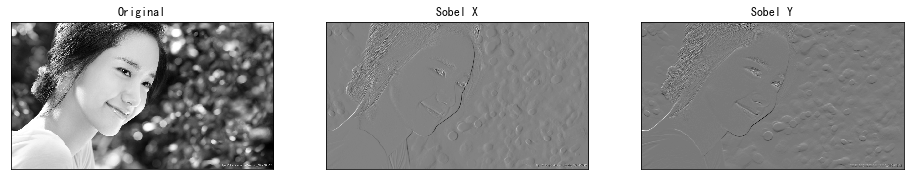

In [7]:
# -*- coding: utf-8 -*-
"""
cv2.Sobel(src, #参数是需要处理的图像；
					ddepth, #图像的深度，-1表示采用的是与原图像相同的深度。目标图像的深度必须大于等于原图像的深度
					dx, #dx和dy表示的是求导的阶数，0表示这个方向上没有求导，一般为0、1、2。
					dy[, 
					dst[, #输出图片
          ksize[,#Sobel算子的大小，必须为1、3、5、7。
          scale[, #缩放导数的比例常数，默认情况下没有伸缩系数；
          delta[, #可选的增量，将会加到最终的dst中，同样，默认情况下没有额外的值加到dst中；
          borderType #判断图像边界的模式。这个参数默认值为cv2.BORDER_DEFAULT。
          ]]]]])  
"""
import cv2
import numpy as np
from matplotlib import pyplot as plt

#读图
img = cv2.imread('images/yun.jpg',0)

sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

#画图
plt.figure(figsize=(16, 9))
plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

#### Canny算法

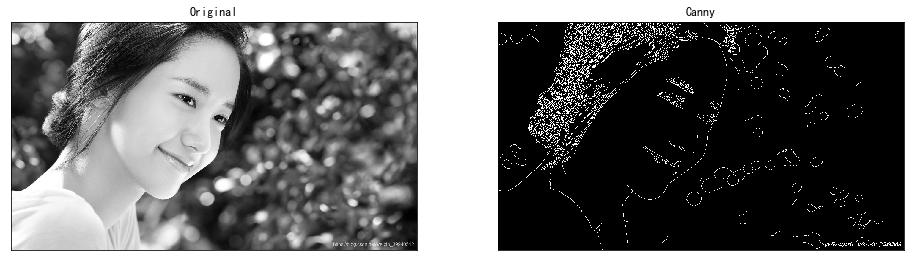

In [6]:
# -*- coding: utf-8 -*-

"""
cv2.Canny(image,            # 输入原图（必须为单通道图）
          threshold1,
          threshold2,       # 较大的阈值2用于检测图像中明显的边缘
          [, edges[,
          apertureSize[,    # apertureSize：Sobel算子的大小
          L2gradient ]]])   # 参数(布尔值)：
                              true： 使用更精确的L2范数进行计算（即两个方向的倒数的平方和再开放），
                              false：使用L1范数（直接将两个方向导数的绝对值相加）。
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

original_img = cv2.imread("images/yun.jpg", 0)

# canny边缘检测
img1 = cv2.GaussianBlur(original_img,(3,3),0)
canny = cv2.Canny(img1, 50, 150)

# 画图
plt.figure(figsize=(16, 9))
plt.subplot(1,2,1),plt.imshow(original_img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2),plt.imshow(canny,cmap = 'gray')
plt.title('Canny'), plt.xticks([]), plt.yticks([])
plt.show()

## 6.6 总结

本节学习了边缘检测的两个算法原理，并使用opencv做了demo演示，想要更深入理解的原理，可以查看opencv源代码，并从低层一步一步coding出来。